# NOTEBOOK 03: PREPROCESSING

In this notebook, the data will be prepared for modeling by following the preprocessing steps used during EDA. The data will be split into training and validation sets ahead of Tfidf vectorization and SVD feature reduction. 

In [19]:
import re, csv, time, json, pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy import sparse

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

np.random.seed(42)

%matplotlib inline

In [30]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[A-z]+_[A-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Word list saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

In [3]:
!ls '../assets/'

1544820504_comments_df.csv     1545272821_eda_words.csv
1544843302_comments_df.csv     1545277666_tfidf_col.csv
1544988010_comments_df.csv     1545277666_y_test.csv
1545241316_clean_target.csv    1545277666_y_train.csv
1545241316_clean_text.csv      1545285057_tfidf_col.csv
1545249401_cvec_coo.npz        cvec_1545266972_coo_col.csv
1545249401_cvec_coo_col.csv    file_log.txt
1545254581_clean_text.csv      test_1545277666_tfidf_coo.npz
1545266972_clean_text.csv      tfidf_1545266972_coo_col.csv
1545266972_cvec_coo.npz        train_1545277666_tfidf_coo.npz
1545266972_tfidf_coo.npz


In [4]:
eda_words = pd.read_csv('../assets/1545272821_eda_words.csv', na_filter=False)

In [5]:
eda_words.head()

,body,libertarian,char_count,word_count,tokens
0,Workers' collective ownership of capital nev...,1,81,12,workers' collective ownership of capital n...
1,hmmmmmmm interesting,1,20,2,hmmmmmmm interesting
2,To be fair credit to Cratchit just for litera...,1,82,15,to be fair credit to cratchit just for ...
3,Game show hosts they re are truly the worst ...,1,68,11,game show hosts they re are truly the ...
4,I think the better explanation is who are the ...,1,73,12,i think the better explanation is who a...


## Count Vectorizing

Count Vectorizing is the process of splitting a body of text into single words and their associated count within the document. This is used as the foundation for model fitting.

In [6]:
X = eda_words.drop('libertarian', axis=1)
y = eda_words['libertarian']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [8]:
custom_stop = [
    'conservative',
    'conservatives',
    'libertarian',
    'libertarians',
    'don',
    'isn',
    'say',
    'way',
    'really',
    'things',
    'going',
    'actually',
    'make',
    've',
    'gt',
    'doesn',
    'does',
    'know',
    'good',
    'want',
    'did',
    'pay',
    'use',
    'thing',
    'sure',
    'didn',
    'like',
    'just',
    'did',
    'll',
    'bad',
    'need',
    'let',
    'lot',
    'libertarian',
    'yes',
    'sub',
    'said',
    'saying',
    'pretty',
    'got',
    'amp',
    'shit',
    'look',
    'aren',
    'x200b',
    '32',
    '43',
    '31',
    '000',
    'yeah',
    'wikitextbot',
    'sneakpeekbot',
    'imguralbumbot',
    
    
]

stop_words = ENGLISH_STOP_WORDS.union(custom_stop)

We saw in EDA that Tfidf identified a more informative syntatical difference between classes, suggesting it may be a better method for class prediction. Since the data is very wide, model fitting will likely perform better after the feature-space has been reduced by SVD, which also works best in conjunction with Tfidf vectorization. For model fitting and prediction, we will use Tfidf or Tfidf/SVD transformed data.

In [9]:
tfidf = TfidfVectorizer(strip_accents = 'unicode',  
                        stop_words = stop_words, 
                        lowercase = True, 
                        min_df = 15, 
                        max_df = 1.0)

Fitting and transforming the training data.

In [10]:
X_train_tfidf_mat = tfidf.fit_transform(X_train['tokens'])

Checking the number of features

In [11]:
len(tfidf.get_feature_names())

11323

Creating a sparse dataframe so the data can be saved out or used for SVD feature reduction.

In [12]:
X_train_tfidf = pd.SparseDataFrame(X_train_tfidf_mat, columns=tfidf.get_feature_names())

In [13]:
X_test_tfidf = pd.SparseDataFrame(tfidf.transform(X_test['tokens']), columns=tfidf.get_feature_names())

Converting to a COO sparse matrix to save out the data

XtrainTFIDF_coo = X_train_tfidf.to_coo()
XtestTFIDF_coo = X_test_tfidf.to_coo()

columns = pd.Series(tfidf.get_feature_names())

formatted_name, now, file_description = filename_format_log(file_path ='../assets/TFIDF_col.csv')
columns.to_csv(formatted_name, index=False)

formatted_name, now, file_description = filename_format_log(file_path ='../assets/XtrainTFIDF_coo.npz')
sparse.save_npz(formatted_name, XtrainTFIDF_coo)

formatted_name, now, file_description = filename_format_log(file_path ='../assets/XtestTFIDF_coo.npz')
sparse.save_npz(formatted_name, XtestTFIDF_coo)

formatted_name, now, file_description = filename_format_log(file_path ='../assets/y_train.csv')
y_train.to_csv(formatted_name, index=False)

formatted_name, now, file_description = filename_format_log(file_path ='../assets/y_test.csv')
y_test.to_csv(formatted_name, index=False)

## SVD

Singular Value Decomposition is a linear algebra method for reducing the dimensionality of a matrix by evaluating which features contain the most information while eliminating colinearities. When used for text-based data in combination with Tfidf Vectorization, each feature is assigned "meaning" based on its usage, allowing for Latent Semantic Analysis (LSA) of a document. This method of compression allows for a importance weight to be assigned to each feature such that little information is lost while size of the data is greatly reduced.

Filling nulls with 0 for SVD.

In [14]:
X_train_tfidf.fillna(0, inplace=True)
X_test_tfidf.fillna(0, inplace=True)

In [15]:
SVD = TruncatedSVD(n_components=2000, random_state=42)
svd_matrix = SVD.fit_transform(X_train_tfidf)
svd_matrix.shape

(137531, 2000)

In [ ]:
svd_test = SVD.transform(X_train_tfidf)

In [21]:
sys.getsizeof(svd_matrix) / 1e9

2.200496112

In [25]:
TrainSVD_coo = sparse.coo_matrix(svd_matrix)

In [54]:
sys.getsizeof(TrainSVD_coo)

56

In [27]:
TrainSVD_coo

<137531x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 268398000 stored elements in COOrdinate format>

In [28]:
TestSVD_coo = sparse.coo_matrix(svd_test)

formatted_name, now, file_description = filename_format_log(file_path ='../assets/XtrainSVD_coo.npz')
sparse.save_npz(formatted_name, TrainSVD_coo)

formatted_name, now, file_description = filename_format_log(file_path ='../assets/XtestSVD_coo.npz')
sparse.save_npz(formatted_name, TestSVD_coo)

formatted_name, now, file_description = filename_format_log(file_path ='../assets/XtrainSVD_raw.csv')
np.savetxt(formatted_name, svd_matrix, delimiter=",")

formatted_name, now, file_description = filename_format_log(file_path ='../assets/XtestSVD_raw.csv')
np.savetxt(formatted_name, svd_test, delimiter=",")

In [33]:
component_names = pd.Series(["component_"+str(i+1) for i in range(2000)])

In [34]:
formatted_name, now, file_description = filename_format_log(file_path ='../assets/SVD_col.csv')
component_names.to_csv(formatted_name, index=False)

Checking the shape of the components matrix, note that 11323 was the original rank of our data.

In [37]:
SVD.components_.shape

(2000, 11323)

Plotting the explained variance to visually understand how much information is captured by the 100 features we selected during SVD. To maximize predictive power, I will set a threshold of 80% information retention to determine the size of the target feature-space.

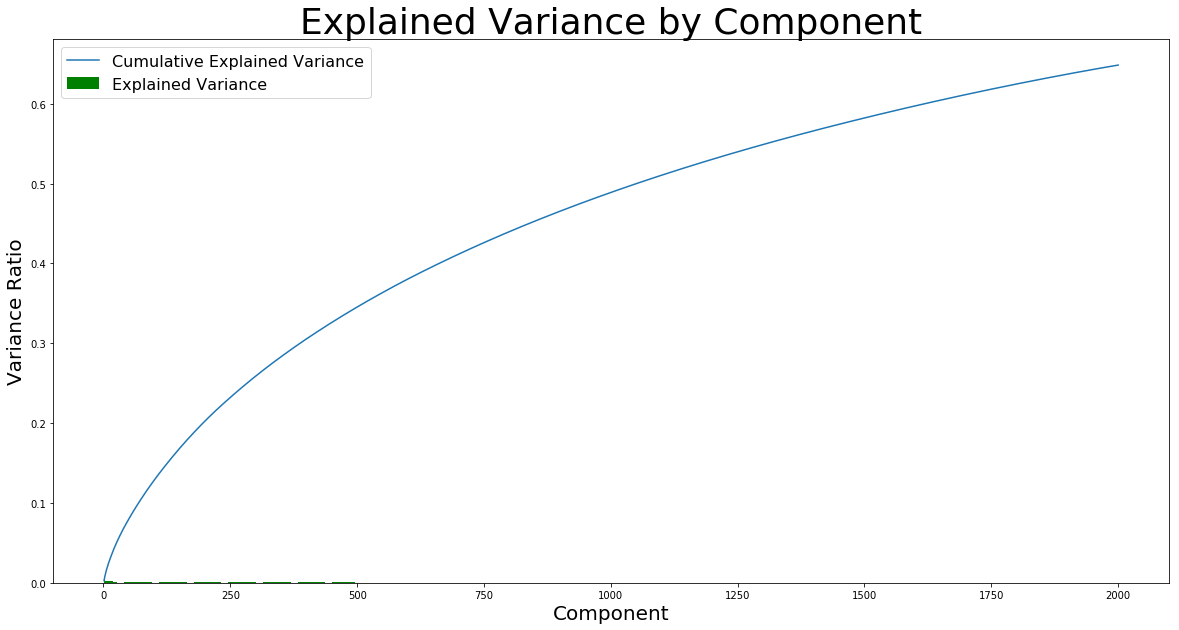

In [38]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(2000))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='Explained Variance')
plt.plot(np.array(range(2000))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='Cumulative Explained Variance')
plt.legend(fontsize=16)
plt.xlabel('Component', fontsize=20)
plt.ylabel('Variance Ratio', fontsize=20)
plt.title('Explained Variance by Component', fontsize=36);

Checking to see how much variance was explained by the feature reduction.

In [39]:
np.cumsum(SVD.explained_variance_)[1450:]

array([0.55805373, 0.55820968, 0.55836555, 0.55852133, 0.55867704,
       0.55883271, 0.55898827, 0.55914372, 0.55929909, 0.55945433,
       0.55960952, 0.55976464, 0.55991953, 0.56007439, 0.56022915,
       0.56038391, 0.56053853, 0.56069311, 0.56084755, 0.56100192,
       0.56115612, 0.5613102 , 0.5614642 , 0.56161814, 0.56177203,
       0.56192584, 0.56207953, 0.56223315, 0.56238662, 0.56254001,
       0.56269328, 0.56284644, 0.56299948, 0.56315239, 0.56330526,
       0.56345802, 0.56361076, 0.5637633 , 0.5639157 , 0.56406806,
       0.56422037, 0.56437263, 0.56452485, 0.564677  , 0.56482899,
       0.56498084, 0.56513259, 0.56528427, 0.56543587, 0.56558742,
       0.56573881, 0.56589013, 0.56604132, 0.56619244, 0.56634346,
       0.56649434, 0.5666452 , 0.56679599, 0.56694668, 0.56709733,
       0.56724786, 0.56739831, 0.56754874, 0.56769904, 0.56784919,
       0.56799935, 0.56814934, 0.56829922, 0.56844897, 0.56859866,
       0.56874828, 0.56889784, 0.56904734, 0.56919666, 0.56934

In [40]:
np.where(np.cumsum(SVD.explained_variance_ratio_) < .8)[0][-1]+1

2000

In [41]:
component_names = ["component_"+str(i+1) for i in range(2000)]
svd_df = pd.SparseDataFrame(svd_matrix,columns=component_names)

In [42]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_1991,component_1992,component_1993,component_1994,component_1995,component_1996,component_1997,component_1998,component_1999,component_2000
0,0.037019,-0.000212,0.001245,-0.015726,-0.012006,0.000506,0.007479,-0.009837,-0.013937,-0.000605,...,-0.002328,0.001012,-0.001449,-0.004495,-0.003386,-0.017899,0.011819,0.001228,0.003964,0.001882
1,0.060159,-0.005050,0.001202,-0.014899,-0.022917,0.000866,0.009888,-0.013411,-0.015295,-0.016358,...,-0.001926,-0.020678,0.005265,-0.006256,0.004927,-0.023348,-0.006556,-0.003822,0.028763,0.011147
2,0.020463,0.001249,0.001282,-0.005800,-0.004521,0.007947,0.007065,-0.006124,-0.005303,-0.002730,...,-0.048518,-0.031312,0.026564,-0.008027,-0.033640,0.018032,-0.012117,-0.009270,-0.021856,-0.019092
3,0.076860,0.008881,0.021480,-0.070961,-0.004598,0.139658,-0.032231,-0.001718,0.022011,0.028361,...,-0.000368,0.005717,-0.005478,-0.012041,0.020129,-0.011111,0.008026,-0.004060,-0.021796,-0.011386
4,0.046109,0.002497,0.004003,-0.016710,-0.008207,0.016202,0.018561,-0.018017,-0.018794,-0.009325,...,0.025005,-0.017626,-0.023984,0.003314,-0.008179,-0.015589,-0.035660,0.019742,-0.017114,-0.010257


In [43]:
loadings = pd.SparseDataFrame(SVD.components_,
                              index=component_names,
                              columns=X_train_tfidf.columns).T

In [44]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)

In [45]:
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_1993,component_1994,component_1995,component_1996,component_1997,component_1998,component_1999,component_2000,abs_component_1,abs_component_2
00,0.000316,0.000029,-0.000110,-0.000047,-0.000005,0.000132,0.000160,-0.000118,-0.000046,-0.000129,...,-0.000211,-0.000898,-0.000603,-0.000491,0.000929,-0.000308,-0.002369,-0.000754,0.000316,0.000029
01,0.000650,-0.000037,0.000099,-0.000533,-0.000129,0.000258,0.000188,-0.000340,-0.000244,-0.000549,...,-0.001565,-0.002111,-0.002589,-0.001454,0.001811,0.001513,-0.002386,-0.000149,0.000650,0.000037
02,0.000426,-0.000006,-0.000003,-0.000309,-0.000194,0.000028,0.000195,-0.000189,-0.000216,-0.000303,...,0.001447,-0.002653,0.000370,-0.000893,0.001520,-0.000340,0.001284,-0.000967,0.000426,0.000006
03,0.000502,-0.000021,0.000296,-0.000045,-0.000181,0.000235,0.000065,-0.000256,-0.000111,-0.000274,...,-0.001030,0.000716,-0.002152,0.000631,-0.000500,0.001196,-0.001306,0.000804,0.000502,0.000021
04,0.000322,-0.000017,0.000157,-0.000048,-0.000102,0.000242,0.000003,-0.000141,-0.000144,-0.000204,...,-0.001627,0.001478,0.000218,-0.000208,-0.001829,0.000093,0.000599,-0.001874,0.000322,0.000017


In [46]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]

,component_1
people,0.480621
think,0.260281
right,0.240610
government,0.188147
trump,0.126642
time,0.112148
free,0.109262
point,0.106321
left,0.106191
work,0.090204


In [47]:
loadings.sort_values('abs_component_2',ascending=False).head(20)[['component_2']]

,component_2
lol,0.974446
people,-0.178235
right,0.079321
government,-0.042384
fucking,0.026298
trump,0.025698
fuck,0.024691
post,0.023291
oh,0.021413
money,-0.016052


In [48]:
svd_df['y_train'] = y_train

In [49]:
svd_df['y_train'].fillna(0, inplace=True)

In [50]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_1992,component_1993,component_1994,component_1995,component_1996,component_1997,component_1998,component_1999,component_2000,y_train
0,0.037019,-0.000212,0.001245,-0.015726,-0.012006,0.000506,0.007479,-0.009837,-0.013937,-0.000605,...,0.001012,-0.001449,-0.004495,-0.003386,-0.017899,0.011819,0.001228,0.003964,0.001882,1.0
1,0.060159,-0.005050,0.001202,-0.014899,-0.022917,0.000866,0.009888,-0.013411,-0.015295,-0.016358,...,-0.020678,0.005265,-0.006256,0.004927,-0.023348,-0.006556,-0.003822,0.028763,0.011147,1.0
2,0.020463,0.001249,0.001282,-0.005800,-0.004521,0.007947,0.007065,-0.006124,-0.005303,-0.002730,...,-0.031312,0.026564,-0.008027,-0.033640,0.018032,-0.012117,-0.009270,-0.021856,-0.019092,1.0
3,0.076860,0.008881,0.021480,-0.070961,-0.004598,0.139658,-0.032231,-0.001718,0.022011,0.028361,...,0.005717,-0.005478,-0.012041,0.020129,-0.011111,0.008026,-0.004060,-0.021796,-0.011386,0.0
4,0.046109,0.002497,0.004003,-0.016710,-0.008207,0.016202,0.018561,-0.018017,-0.018794,-0.009325,...,-0.017626,-0.023984,0.003314,-0.008179,-0.015589,-0.035660,0.019742,-0.017114,-0.010257,1.0


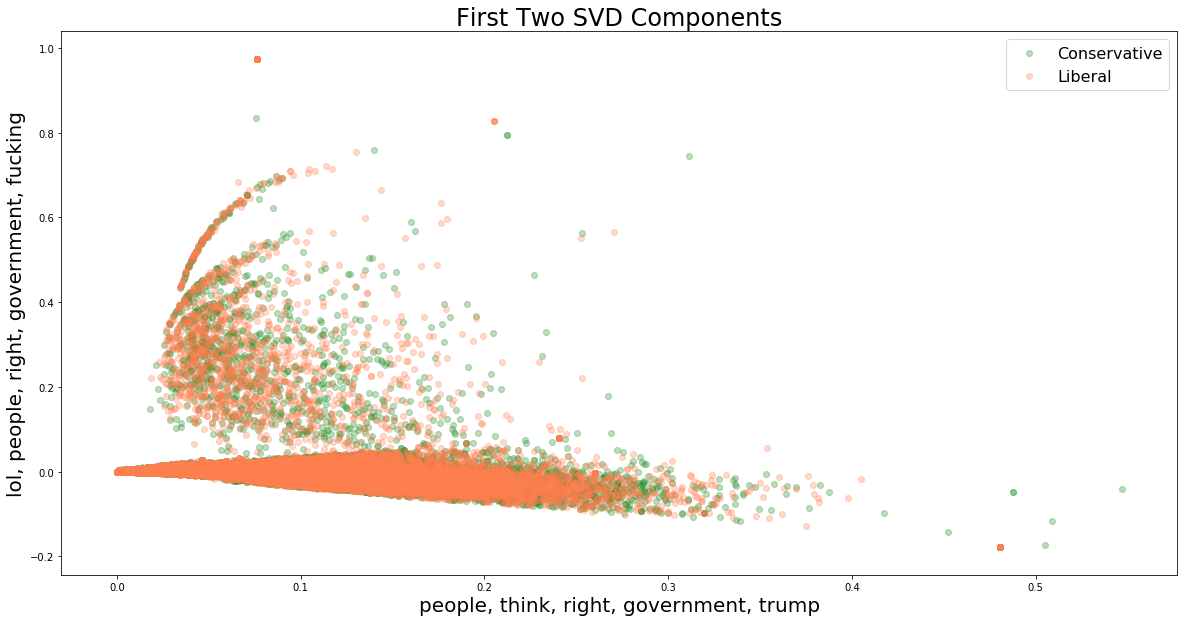

In [51]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df[['component_1']][svd_df['y_train']==0], svd_df[['component_2']][svd_df['y_train']==0], c='forestgreen', alpha=.3)
plt.scatter(svd_df[['component_1']][svd_df['y_train']==1], svd_df[['component_2']][svd_df['y_train']==1], c='coral', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('abs_component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('abs_component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('First Two SVD Components', fontsize=24)
plt.legend(['Conservative', 'Liberal'], fontsize=16);

plt.savefig('../images/SVD_first2.png', dpi=300)

In [53]:
svd_sparse = sparse.csr_matrix(svd_matrix)

In [ ]:
cos_sim_mat = cosine_similarity(svd_sparse, svd_sparse)
cos_sim_mat.shape

In [ ]:
np.argsort(cos_sim_mat[1])[:-11:-1]

In [ ]:
np.sort(cos_sim_mat[1])[:-11:-1]

In [ ]:
df.loc[np.argsort(cos_sim_mat[50])[:-11:-1], :]